In [63]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Weighted overlay
Here's a recipe for assigning a quantity from one set of polygons to another, based on the areas of overlap.

<Axes: >

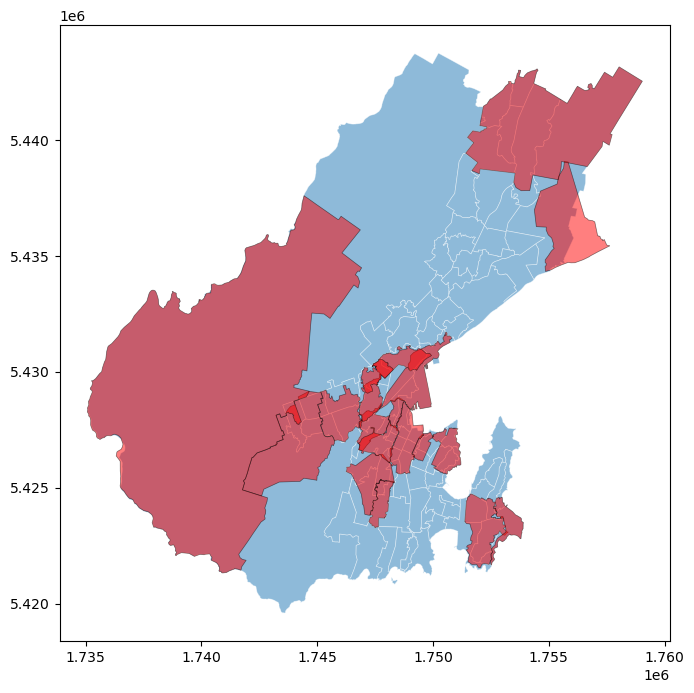

In [64]:
sa2 = gpd.read_file("data/sa2-wellington.gpkg")
school_zones = gpd.read_file("data/school-zones.gpkg")
ax = sa2.plot(alpha = 0.5, ec = "w", lw = 0.5, figsize = (8, 8))
school_zones.plot(ax = ax, fc = "red", alpha = 0.5, ec = "k", lw = 0.5)

We need the areas of the SA2 polygons.

In [65]:
sa2["sa2_area"] = sa2.area
sa2

,sa2_code,CURPop,name,pop_density,geometry,sa2_area
0,247501,3513,Mākara-Ohariu,19.825158,"MULTIPOLYGON (((1743730.013 5427981.185, 17438...",1.771991e+08
1,247600,5280,Tawa North,3656.350966,"MULTIPOLYGON (((1752863.175 5440621.446, 17528...",1.444063e+06
2,247700,5610,Linden,5014.032699,"MULTIPOLYGON (((1753353.104 5441501.232, 17533...",1.118860e+06
3,247800,6303,Tawa South,2473.668022,"MULTIPOLYGON (((1752776.039 5439434.788, 17527...",2.548038e+06
4,247900,4527,Tawa Central,2955.771118,"MULTIPOLYGON (((1753243.083 5439050.389, 17531...",1.531580e+06
...,...,...,...,...,...,...
81,254800,4188,Miramar East,4940.824228,"MULTIPOLYGON (((1752942.33 5423747.776, 175293...",8.476319e+05
82,254900,4617,Miramar South,4691.789569,"MULTIPOLYGON (((1751414.009 5423486.159, 17513...",9.840595e+05
83,255000,57,Rongotai,29.340304,"MULTIPOLYGON (((1751632.544 5422047.177, 17516...",1.942720e+06
84,255100,4959,Strathmore (Wellington City),3396.707351,"MULTIPOLYGON (((1751982.866 5421779.596, 17519...",1.459943e+06


Next, overlay the school zones and the SA2s, and calculate the areas of the intersections.

In [66]:
school_zones_sa2 = school_zones.overlay(sa2)
school_zones_sa2["area"] = school_zones_sa2.area

region = gpd.GeoSeries([sa2.union_all().union(school_zones.union_all())])

/opt/miniconda3/envs/intro-python-2/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/miniconda3/envs/intro-python-2/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


Now we can estimate populations of the school zones, make a new dataframe with this information and merge it back into the school zones data. 

In [67]:
school_zones_sa2["pop"] = \
    school_zones_sa2.CURPop * school_zones_sa2.area / school_zones_sa2.sa2_area
school_zone_pops = school_zones_sa2 \
    .groupby("School_ID", as_index = False) \
    .agg({"pop": "sum",
          "area": "sum"})
school_zones = school_zones.merge(school_zone_pops)
school_zones["pop_density"] = school_zones["pop"] / school_zones.area * 1e6

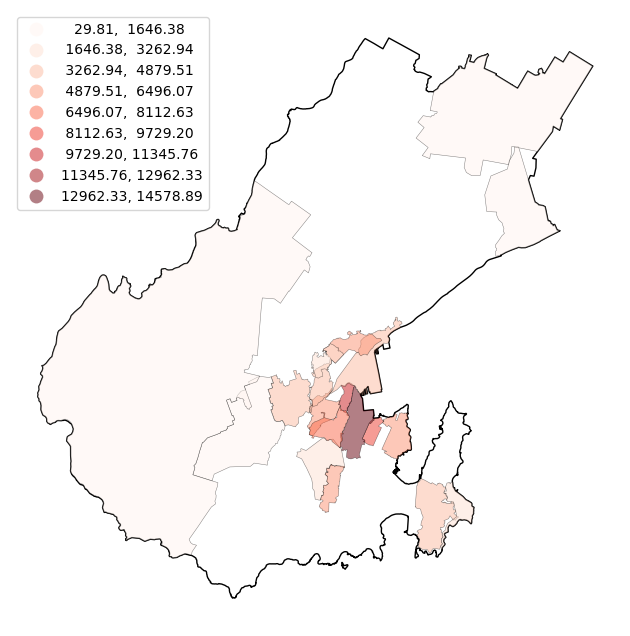

In [69]:
ax = region.plot(fc = "#00000000", ec = "k", figsize = (8, 8))
school_zones.plot(ax = ax, column = "pop_density", cmap = "Reds", alpha = 0.5,
                  k = 9, scheme = "equalinterval", ec = "k", lw = 0.35, 
                  legend = True, legend_kwds = {"loc": "upper left"})
ax.set_axis_off()
plt.show()